In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import random as rd
from random import gauss
from scipy import integrate as integ

# Final project Math 578 : Comparative Analysis of Data Assimilation Techniques
Author : Pauline Lelandais (ID #260679472), Dec. 2020 at McGill University

We will study two data assimilation techniques on the Lorenz system (non-linear, choatic ODE). To this aim we present the next two functions where we have implemented a 4th order Runge Kutta method for this dynamical system (with parameter to be chosen).

In [3]:
def RK_Lorenz(X,t, h):
    #give yn, tn and f, computes y(n+1)
    X=np.array(X)
    temp1=Lorenz(X, t)
    temp2=Lorenz(X + h*temp1/2, t +h/2)
    temp3=Lorenz(X + h*temp2/2, t +h/2)
    temp4=Lorenz(X + h*temp3, t +h)
    nxt= X + h*(temp1/6 + temp2/3 + temp3/3 + temp4/6)
    return nxt

In [4]:
def Lorenz (X, t):
    #This is f in y'(t)=f(t)
    x=param[0]*(X[1]-X[0])
    y=X[0]*(param[1]-X[2])-X[1]
    z=-1*param[2]*X[2]+X[0]*X[1]
    return np.array([x, y, z])

## Extended Kalman Filter

We start by generating a set of normally distributed noisy measurements to feed out filter. Doing this indepedently allows for reproducibility.

In [5]:
def gen_meas(nombre, length, X_list):
    meas_list=[rd.randint(0, length) for i in range(nombre)]
    meas_list.sort()

    X2_list=[]
    t2_list=[i*h for i in meas_list]
    for i in range(len(meas_list)):
        temp=[]
        for j in range(3):
            x=gauss(mu, sigma)
            temp.append(X_list[meas_list[i]][j]+x)
        X2_list.append(temp)
    return [t2_list, X2_list]

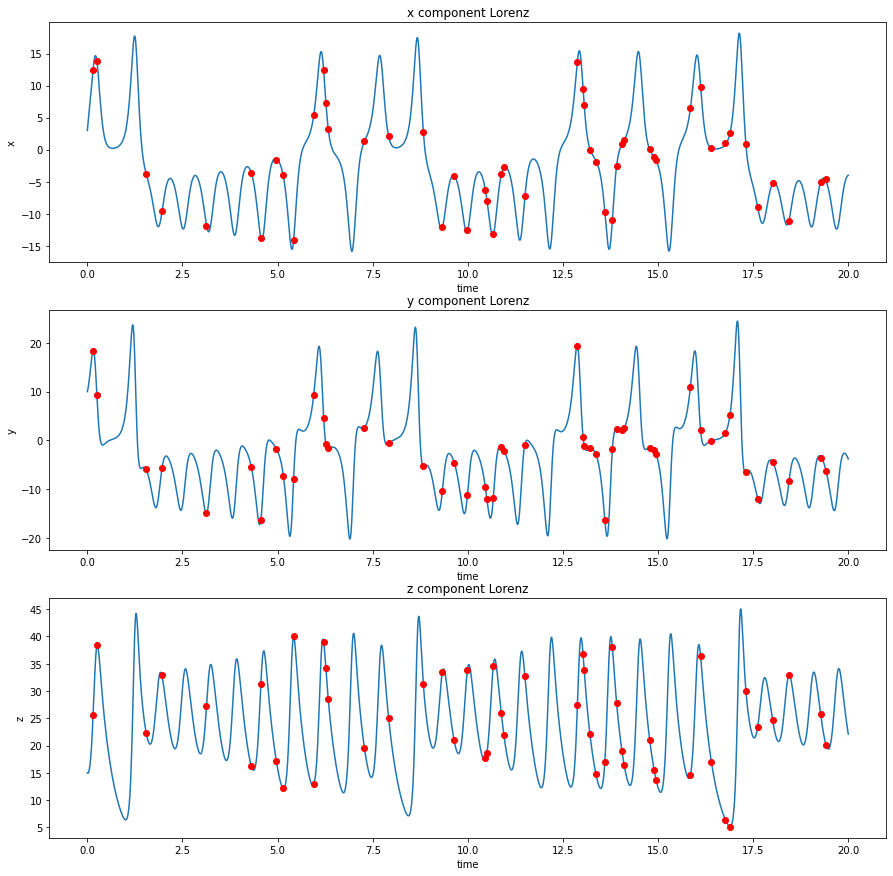

In [6]:
param=[10., 28., 8/3]
char=["x", "y", "z"]
h=.01
pivot=20.
n=math.ceil(pivot/h)

fig, axs = plt.subplots(3,figsize=(15,15))

rd.seed(1) #This seed checks out
meas=50
mu=0.
sigma=0.1

X1_list=[[3., 10., 15.]]
t_list=[i*h for i in range(n+1)]
for i in range (n):
    X1_list.append(RK_Lorenz(X1_list[i], t_list[i], h))
    
meas_list=[rd.randint(0, n) for i in range(meas)]

result=gen_meas(meas, n, X1_list)
X2_list=result[1]
t2_list=result[0]
    
for i in range(3):
    list1=[]
    list2=[]
    for j in range(len(X1_list)):
        list1.append(X1_list[j][i])
    for j in range(len(X2_list)):
        list2.append(X2_list[j][i])
    axs[i].plot(t_list, list1)
    axs[i].plot(t2_list, list2, 'ro')
    axs[i].set_title(r'{} component Lorenz'.format(char[i]))
    axs[i].set_xlabel(r'time')
    axs[i].set_ylabel('{}'.format(char[i]))
    

In [7]:
def Lor_mat(X):
    matrix=[[-param[0], param[0],        0.],
            [ param[1],      -1.,     -X[0]],
            [     1/2*X[1],     1/2*X[0], -param[2]]]
    result=np.matmul(np.array(matrix), X)
    return result

In [8]:
def RK4_mat(X):
    #give yn, tn and f, computes y(n+1)
    X=np.array(X)
    temp1=Lor_mat(X)
    temp2=Lor_mat(X + h/2*temp1)
    temp3=Lor_mat(X + h/2*temp2)
    temp4=Lor_mat(X + h*temp3)
    nxt= X + h*(1/6*temp1 + 1/3*temp2 + 1/3*temp3 + 1/6*temp4)
    return nxt

In [9]:
def FE(X):
    matrix=[[1-h*param[0], h*param[0],       0],
            [h*param[1]  , 1-h       , -h*X[0]],
            [h/2*X[1]      , h/2*X[0]    , 1-h*param[2]]]
    return np.array(matrix)

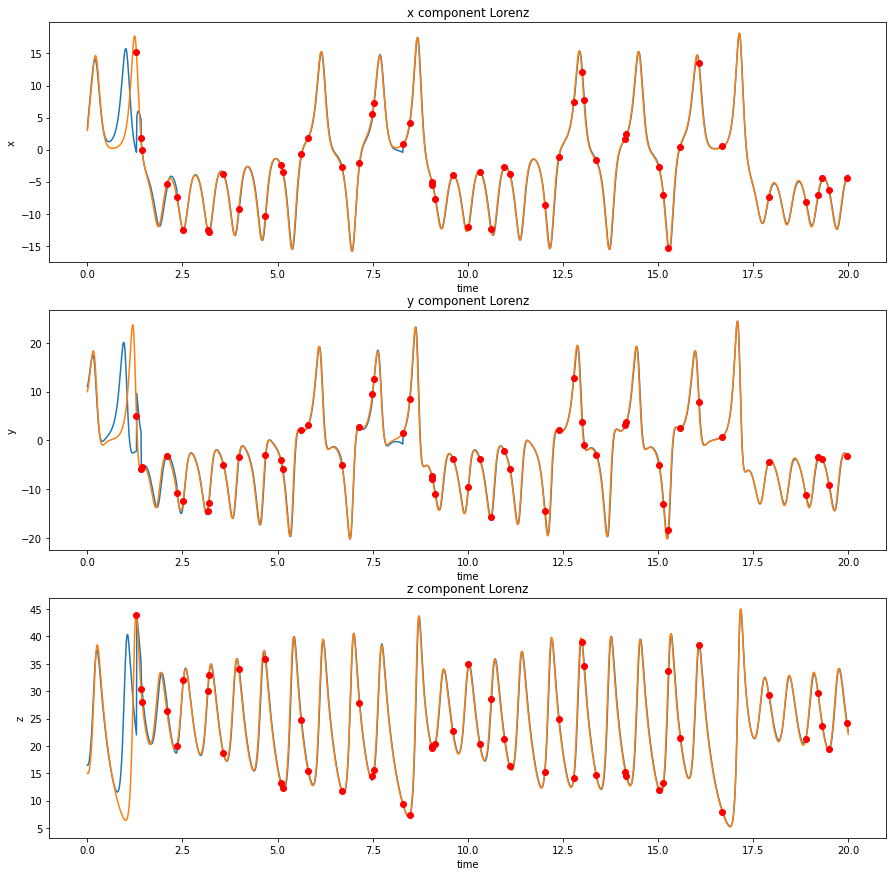

In [11]:
param=[10., 28., 8/3]
char=["x", "y", "z"]
h=.01
pivot=20.
n=math.ceil(pivot/h)

fig, axs = plt.subplots(3,figsize=(15,15))

rd.seed(1) #This seed checks out
meas=50
mu=0.
sigma=0.1
    
t_list=[i*h for i in range(n+1)]
X1_list=[[3., 10., 15.]]
for i in range (n):
    X1_list.append(RK_Lorenz(X1_list[i], t_list[i], h))

result=gen_meas(meas, n, X1_list)
Z_list=[]
for i in range(len(result[0])):
    Z_list.append([result[0][i], result[1][i]])

X_list=[[3.3, 11., 16.5]]

P=np.identity(3)
H=np.identity(3)
Q_eps=0.00001
Q=Q_eps*np.identity(3)
R=sigma*sigma*np.identity(3)
#R=Q_eps*np.identity(3)
#R=np.identity(3)


for i in range(n):#print ("This is the ",i,"th time")
    EKF=0
    index=-2
    for j in range(len(Z_list)):
        if i*h == Z_list[j][0]:
            EKF=1
            index=j#print ("We have input!")
    #time update#print ("This is X :", X_list[i])#a=A(X_list[i])
    omega=np.array([gauss(0, Q_eps) for i in range(3)])
    Xnxt_time=RK4_mat(X_list[i])+omega#print ("This is A(X) +err :",Xnxt_time)#Xnxt_time=RK_Lorenz(X_list[i], t_list[i], h)
    a=FE(Xnxt_time)
    temp=np.matmul(a, P)
    Pnxt_time=np.matmul(temp, np.transpose(a))+Q
    
    if EKF:
        #meas update
        #print ("The measurement is :", Z_list[index][1])
        temp1=np.linalg.inv(Pnxt_time+R)
        #print (len(Pnxt_time+R))
        K=np.matmul(Pnxt_time, temp1)
        temp2=Z_list[index][1]-Xnxt_time
        #print ("This is the difference :", temp2)
        Xnxt_meas=Xnxt_time+np.matmul(K, temp2)
        temp3=np.identity(3)-np.matmul(K, H)
        Pnxt_meas=np.matmul(temp3, Pnxt_time)
    
        X_list.append(Xnxt_meas)
        P=Pnxt_meas
    else :
        #X_list.append(RK_Lorenz(X_list[i], t_list[i], h))
        X_list.append(Xnxt_time)
        P=Pnxt_time

for k in range(3):
    list1=[]
    list2=[]
    list3=[]
    for j in range(len(X_list)):
        list1.append(X_list[j][k])
        list2.append(X1_list[j][k])
    for j in range(len(result[1])):
        list3.append(result[1][j][k])
    axs[k].plot(t_list, list1)
    axs[k].plot(t_list, list2)
    axs[k].plot(result[0], list3, 'ro')
    axs[k].set_title(r'{} component Lorenz'.format(char[k]))
    axs[k].set_xlabel(r'time')
    axs[k].set_ylabel('{}'.format(char[k]))

## Chaos Synchronisation

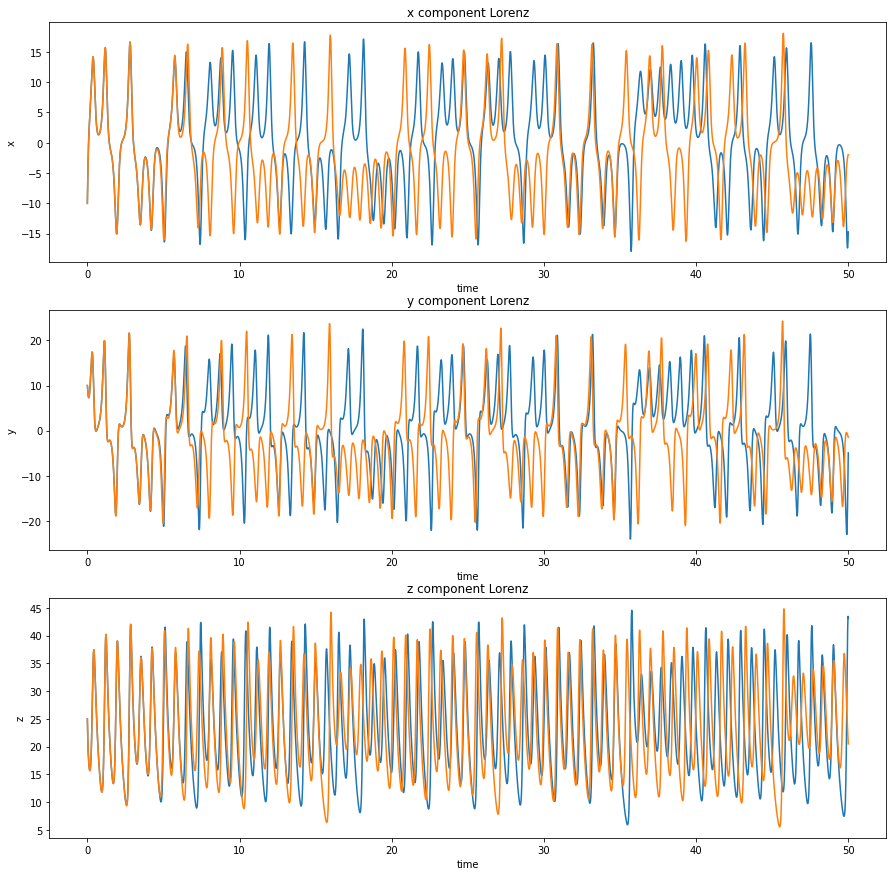

In [29]:
param=[10., 28., 8/3]
char=["x", "y", "z"]
h=.01
pivot=50.
n=math.ceil(pivot/h)

fig, axs = plt.subplots(3,figsize=(15,15))

X1_list=[[-10., 10., 25.]]
X2_list=[[-10.01, 10., 25.]]
t_list=[i*h for i in range(n+1)]

for i in range (n):
    X1_list.append(RK_Lorenz(X1_list[i], t_list[i], h))
    X2_list.append(RK_Lorenz(X2_list[i], t_list[i], h))
    
for i in range(3):
    list1=[]
    list2=[]
    for j in range(len(X1_list)):
        list1.append(X1_list[j][i])
        list2.append(X2_list[j][i])
    axs[i].plot(t_list, list1)
    axs[i].plot(t_list, list2)
    axs[i].set_title(r'{} component Lorenz'.format(char[i]))
    axs[i].set_xlabel(r'time')
    axs[i].set_ylabel('{}'.format(char[i]))

In [30]:
def L2_norm(vector):
    n=len(vector)
    norm=0
    for i in range(n):
        temp=vector[i]*vector[i]
        norm+=temp
    norm=math.sqrt(norm)
    return norm

In [31]:
def logscale (array):
    n=len(array)
    new=[]
    for i in range(n):
        temp=math.log(array[i])
        new.append(temp)
    return new

Avergage Lyapunov Exponent : 0.9108410385642827


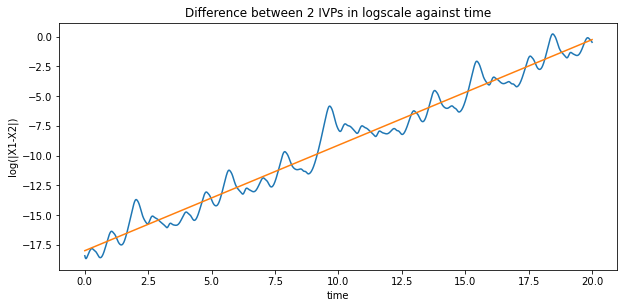

In [32]:
param=[10., 28., 8/3]
h=.01
pivot=20.
n=math.ceil(pivot/h)
it=30

fig = plt.figure(figsize=(10,10)) #graph setup
ax1 = fig.add_subplot(211)

rd.seed(1)
eps=0.00000001
initial=[[-10., 10., 25.]]

for i in range(it-1):
    initial.append([-10.+rd.random(), 10.+rd.random(), 25.+rd.random()])

somme=0

for k in range(it):
    #X1_list=[[-10., 10., 25.]]
    #X2_list=[[-10.+eps, 10., 25.]]
    X1_list=[initial[k]]
    X2_list=[[X1_list[0][0]+eps,X1_list[0][1], X1_list[0][2]] ]
    t_list=[i*h for i in range(n+1)]
    diff_list=[]

    for i in range (n):
        X1_list.append(RK_Lorenz(X1_list[i], t_list[i], h))
        X2_list.append(RK_Lorenz(X2_list[i], t_list[i], h))
    
    for i in range(len(X1_list)):
        diff_list.append(L2_norm(np.array(X1_list[i])-np.array(X2_list[i])))
    
    m, b = np.polyfit(t_list, logscale(diff_list) , 1)
    somme+=m
    best=[]
    for i in range(len(t_list)):
        best.append(m*t_list[i]+b)

ax1.plot(t_list, logscale(diff_list))
ax1.plot(t_list, best)
ax1.set_title(r'Difference between 2 IVPs in logscale against time')
ax1.set_xlabel(r'time')
ax1.set_ylabel('log(|X1-X2|)')

ALE=somme/it

print ("Avergage Lyapunov Exponent :", ALE)

In [33]:
def Coupled (t, X):
    x1=param[0]*(X[1]-X[0]) #+alpha*(X[3]-X[0])
    y1=X[0]*(param[1]-X[2])-X[1]
    z1=-1*param[2]*X[2]+X[0]*X[1]
    x2=param[0]*(X[4]-X[3])+alpha*(X[0]-X[3])
    y2=X[3]*(param[1]-X[5])-X[4]
    z2=-1*param[2]*X[5]+X[3]*X[4]
    return np.array([x1, y1, z1, x2, y2, z2])

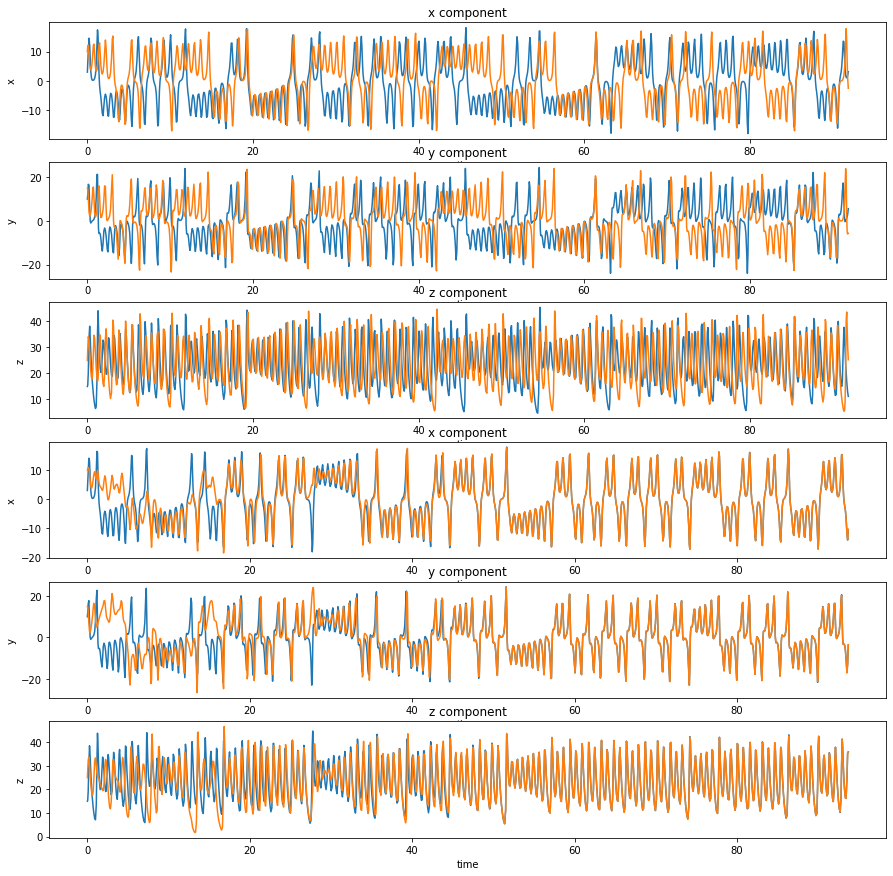

In [34]:
param=[10., 28., 8/3]
H=[[1.,0.,0.], [0.,0.,0.], [0.,0.,0.]]
char=["x", "y", "z"]
h=0.01
pivot=70.
n=math.ceil(pivot/h)

fig, axs = plt.subplots(6,figsize=(15,15))

alpha_list=[.4, 7.5]

k=0
for alpha in alpha_list:
    X1_list=[[3., 10., 15.]]
    X2_list=[[10., 15., 25.]]
    #t_list=[i*h for i in range(n+1)]
    t_list=[0.0]
    X=X1_list[0].copy()
    for j in range(len(X2_list[0])):
        X.append(X2_list[0][j])
        
    result=integ.RK45(Coupled, t_list[0], X, 1200)
    for i in range(1200):
        result.step()

        X1_list.append([result.y[0], result.y[1], result.y[2]])
        X2_list.append([result.y[3], result.y[4], result.y[5]])
        t_list.append(result.t)
    
    for i in range(3):
        list1=[]
        list2=[]
        for j in range(len(X1_list)):
            list1.append(X1_list[j][i])
            list2.append(X2_list[j][i])
        axs[i+k].plot(t_list, list1)
        axs[i+k].plot(t_list, list2)
        axs[i+k].set_title(r'{} component'.format(char[i]))
        axs[i+k].set_xlabel(r'time')
        axs[i+k].set_ylabel('{}'.format(char[i]))
    k+=3